Meltome atlas download doesn't work --> http://meltomeatlas.proteomics.wzw.tum.de:5003/    
ProteomicsDB data is difficult to downlaod --> https://www.proteomicsdb.org/  
PRIDE FTP might contain data needed --> https://www.ebi.ac.uk/pride/archive/projects/PXD011929   




In [1]:
import re
import json
import math

from pathlib import Path
from pandas import read_csv, DataFrame

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

from sklearn.model_selection import train_test_split

In [2]:
uniprot_accesson_regex = re.compile("([OPQ][0-9][A-Z0-9]{3}[0-9]|[A-NR-Z][0-9]([A-Z][A-Z0-9]{2}[0-9]){1,2})")

In [3]:
data_path = Path('') / '..' / 'data' / 'meltome'
split_path = Path('') / '..' / 'splits' / 'meltome'


cross_data_path = data_path / 'cross-species.csv'
human_data_path = data_path / 'human.csv'
human_sequences_path = data_path / 'human_sequences.tsv'

In [4]:
cross_data = read_csv(cross_data_path)
human_data = read_csv(human_data_path)
human_sequences_data = read_csv(human_sequences_path, sep='\t')

/Users/chdallago/miniconda3/envs/bio-benchmarks/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (1,4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
# Some data cleaning
cross_data.dropna(subset=['Protein_ID', 'run_name'], inplace=True)

In [6]:
cross_data[:5]

,run_name,Protein_ID,gene_name,meltPoint,channel,fold_change,temperature
0,Bacillus subtilis_168_lysate_R1,C0H3Q1_ytzI,ytzI,NaN,TMT126,0.999203,30.0
1,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT126,0.999203,30.0
2,Bacillus subtilis_168_lysate_R1,C0H3V8_yyzM,yyzM,43.373369,TMT126,0.999203,30.0
3,Bacillus subtilis_168_lysate_R1,C0H3Y1_yhzD,yhzD,40.693719,TMT126,0.999203,30.0
4,Bacillus subtilis_168_lysate_R1,C0H3Z2_yjzH,yjzH,NaN,TMT126,0.999203,30.0


In [7]:
cross_data[cross_data['Protein_ID'].str.contains('C0H3V2') == True]

,run_name,Protein_ID,gene_name,meltPoint,channel,fold_change,temperature
1,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT126,0.999203,30.0
45627,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT127H,1.102669,36.0
91253,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT127L,1.225128,32.9
136879,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT128H,0.896313,43.2
182505,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT128L,1.317735,39.6
228131,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT129H,0.728182,50.4
273757,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT129L,0.865444,46.8
319383,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT130H,0.402074,57.1
365009,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT130L,0.705247,54.0
410635,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT131L,0.435728,60.0


In [8]:
human_data[:3]

,gene_name,cell_line_or_type,fold_change,temperature,meltPoint,quan_norm_meltPoint
0,A1CF,HepG2,0.999986,37.0,41.945567,43.719078
1,A1CF,HepG2,0.999986,37.0,42.112354,43.719419
2,A1CF,HepG2,0.999986,37.0,44.141517,43.401106


In [9]:
human_data[human_data['gene_name'].str.contains('BRCA') == True]

,gene_name,cell_line_or_type,fold_change,temperature,meltPoint,quan_norm_meltPoint
17305,BRCA1,HEK293T,0.999986,37.0,47.781019,46.940926
17306,BRCA1,HEK293T,0.999986,37.0,47.352790,46.018048
17307,BRCA1,HL60,0.999986,37.0,46.278582,45.179063
17308,BRCA1,HL60,0.999986,37.0,46.421850,45.237606
17309,BRCA1,Jurkat,0.999986,37.0,46.370902,46.794503
...,...,...,...,...,...,...
1689665,BRCA2,HL60,0.010832,67.0,46.570625,45.417062
1689666,BRCA2,HepG2,0.003576,67.0,54.425721,53.678516
1689667,BRCA2,HepG2,0.014984,67.0,53.319431,52.637081
1689668,BRCA2,HepG2,0.013649,67.0,52.855853,52.421773


In [10]:
human_data[human_data['gene_name'].str.contains('BRCA') == True]['quan_norm_meltPoint'].unique()

array([46.94092578, 46.01804849, 45.17906347, 45.2376058 , 46.7945031 ,
       47.57939356, 56.97350571, 45.417062  , 53.67851555, 52.6370811 ,
       52.42177281, 54.68659949])

In [11]:
human_data[human_data['gene_name'].str.contains('BRCA') == True]['meltPoint'].unique()

array([47.78101895, 47.35278955, 46.27858184, 46.42184959, 46.37090242,
       47.0086505 , 56.23910676, 46.57062548, 54.42572146, 53.3194311 ,
       52.85585264, 55.18530458])

In [12]:
# Get all human proteins from SwissProt (https://www.uniprot.org/uniprot/?query=*&fil=organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22+AND+reviewed%3Ayes&sort=score)
# Include: primary gene name and sequence
# Download as TSV!

In [13]:
human_sequences_data.columns

Index(['Entry', 'Entry name', 'Status', 'Protein names', 'Gene names',
       'Organism', 'Length', 'Subcellular location [CC]', 'Entry.1',
       'Gene names  (primary )', 'Sequence'],
      dtype='object')

In [14]:
gene_sequence_mapping = {}

for gene_name in human_data['gene_name'].unique():
    elements = human_sequences_data[human_sequences_data['Gene names  (primary )'] == gene_name].to_dict('records')
    
    if len(elements) < 1:
        elements = human_sequences_data[human_sequences_data['Gene names'].str.contains(gene_name) == True].to_dict('records')
    
    if len(elements) > 0:
        first_element = elements[0]
        
        gene_sequence_mapping[gene_name] = {
            'uniprotAccession': first_element['Entry'],
            'sequence': first_element['Sequence'],
        }

/Users/chdallago/miniconda3/envs/bio-benchmarks/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Group by run_name and Protein_ID.
The melting point (meltPoint) will be the same for each grouped item
Then, there are the channel, temperature and fold change

## Structure idea:
In JSON format:
```json
{
  proteinId: XX,
  uniprotAccession: ???,
  runName: YY,
  meltingPoint: ZZ,
  quantNormMeltingPoint: KK,
  meltingBehaviour: [
    {
      tempertaure: temp,
      fold_change: fchg,
      channel: channel
    },
    {
      tempertaure: temp,
      fold_change: fchg,
      channel: channel
    },
    ...
  ]
}
```


In [15]:
proteins = list()

In [16]:
# For cross_data

def add_group_to_proteins(group):
    first_hit = group.iloc[0]
    
    melting_behaviour = group[['temperature', 'channel', 'fold_change']].to_dict('records')
    
    protein = {
        'proteinId': first_hit['Protein_ID'],
        'uniprotAccession': None,
        'runName': first_hit['run_name'],
        'meltingPoint': first_hit['meltPoint'],
        'meltingBehaviour': melting_behaviour
    }
    
    uniprot_match = re.search(uniprot_accesson_regex, first_hit['Protein_ID'])
    
    if uniprot_match:
        protein['uniprotAccession'] = uniprot_match.group()
    
    proteins.append(protein)

cross_data.groupby(['Protein_ID', 'run_name']).apply(add_group_to_proteins)

""


In [ ]:
# Print all the UniProt Accessions in order to use the UniProt mapping service (https://www.uniprot.org/uploadlists/)
# to download all sequences in bulk

";".join([protein['uniprotAccession'] for protein in proteins if protein['uniprotAccession']])

# this resulted in: 34251 out of 34253 UniProtKB AC/ID identifiers were successfully mapped to 34236 UniProtKB IDs in the table below.

In [18]:
sequences_dict = {}

for sequence in SeqIO.parse(data_path / "sequences.fasta", "fasta"):    
    sequences_dict[sequence.id.split('|')[1]] = str(sequence.seq)

In [19]:
for protein in proteins:
    if protein['uniprotAccession']:
        match = sequences_dict.get(protein['uniprotAccession'])
        
        if match:
            protein['sequence'] = match

In [20]:
# For human_data

def add_group_to_proteins(group):
    first_hit = group.iloc[0]
    
    melting_behaviour = group[['temperature', 'fold_change']].to_dict('records')
    
    protein = {
        'proteinId': first_hit['gene_name'],
        'uniprotAccession': None,
        'runName': first_hit['cell_line_or_type'],
        'meltingPoint': first_hit['meltPoint'],
        'quantNormMeltingPoint': first_hit['quan_norm_meltPoint'],
        'meltingBehaviour': melting_behaviour
    }
    
    uniprot_match = gene_sequence_mapping.get(first_hit['gene_name'])
    
    if uniprot_match:
        protein['uniprotAccession'] = uniprot_match['uniprotAccession']
        protein['sequence'] = uniprot_match['sequence']
    
    proteins.append(protein)


human_data.groupby(['gene_name', 'cell_line_or_type', 'meltPoint']).apply(add_group_to_proteins)

""


In [21]:
with open(split_path / "full_dataset.json", "w") as outfile:
    json.dump(proteins, outfile)

In [22]:
protein_sequences = list()

for protein in proteins:
    if protein.get('sequence') \
    and protein.get('meltingPoint') \
    and not math.isnan(protein.get('meltingPoint'))\
    and protein.get('runName'):
        
        protein_sequences.append(
            SeqRecord(
                Seq(protein.get('sequence')),
                id=f"{protein.get('uniprotAccession')}_{'_'.join(protein.get('runName').split(' '))}",
                description=f"MELTING_POINT={protein.get('meltingPoint')}"
            )
        )

In [23]:
SeqIO.write(protein_sequences, split_path / "full_dataset_sequences.fasta", "fasta")

201283

After having run MMSeqs2 to cluster the sequences, we can read in the TSV file to split the dataset

In [24]:
sequence_clusters = read_csv(split_path / "meltome_PIDE20_clusters.tsv", sep="\t")
sequence_clusters.drop_duplicates(inplace=True)

In [25]:
sequence_clusters[sequence_clusters.duplicated("cluster_component")]

,cluster_representative,cluster_component
28424,O60331_HAOEC,Q99755_HAOEC
35560,E9Q9E4_Mus_musculus_BMDC_lysate,P11802_HAOEC


In [26]:
cluster_representatives = sequence_clusters.cluster_representative.unique()
cluster_components = sequence_clusters.cluster_component.unique()

print(f"Theres {len(cluster_representatives)} cluster representatives and "
      f"{len(cluster_components)} sequences in total.")

Theres 15666 cluster representatives and 84030 sequences in total.


In [64]:
train, test = train_test_split(cluster_representatives, test_size=0.2, random_state=11)
train = set(train)
test = set(test)

In [65]:
len(train)

12532

In [66]:
len(test)

3134

In [67]:
clustered_set = list()
full_set = list()
mixed_set = list()

for protein in proteins:
    if protein.get('sequence') \
    and protein.get('meltingPoint') \
    and not math.isnan(protein.get('meltingPoint'))\
    and protein.get('runName'):
        
        key = f"{protein.get('uniprotAccession')}_{'_'.join(protein.get('runName').split(' '))}"
        
        if key in possibilities:
            hits = sequence_clusters[sequence_clusters.cluster_component == key].values
            cluster_rep_key = hits[0][0]


            if cluster_rep_key in train:
                full_set.append({
                    'sequence': protein.get('sequence'),
                    'target': protein.get('meltingPoint'),
                    'set': 'train'
                })
                
                mixed_set.append({
                    'sequence': protein.get('sequence'),
                    'target': protein.get('meltingPoint'),
                    'set': 'train'
                })
            elif cluster_rep_key in test:
                full_set.append({
                    'sequence': protein.get('sequence'),
                    'target': protein.get('meltingPoint'),
                    'set': 'test'
                })

            possibilities.remove(key)

            if key in train:
                clustered_set.append({
                    'sequence': protein.get('sequence'),
                    'target': protein.get('meltingPoint'),
                    'set': 'train'
                })
                train.remove(key)
            elif key in test:
                clustered_set.append({
                    'sequence': protein.get('sequence'),
                    'target': protein.get('meltingPoint'),
                    'set': 'test'
                })
                
                mixed_set.append({
                    'sequence': protein.get('sequence'),
                    'target': protein.get('meltingPoint'),
                    'set': 'test'
                })
                test.remove(key)

15666

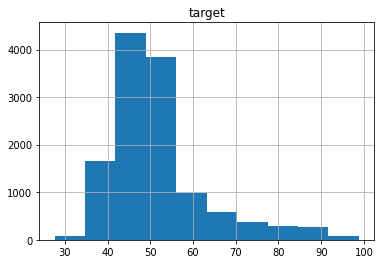

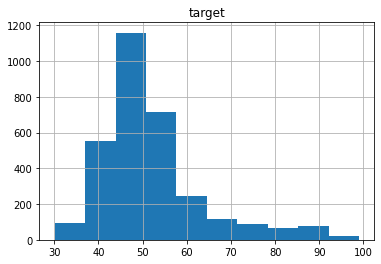

In [69]:
# 2021.08.26
# Numerically, there is little difference between the three splits. As such: we only keep the mixed split.

# clustered_set_df = DataFrame.from_records(clustered_set)
# clustered_set_df[clustered_set_df.set == "train"].hist()
# clustered_set_df[clustered_set_df.set == "test"].hist()
# len(clustered_set_df)

31123

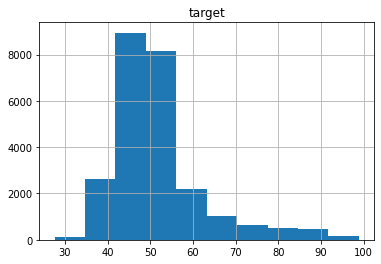

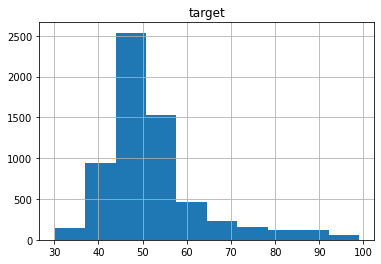

In [71]:
# 2021.08.26
# Numerically, there is little difference between the three splits. As such: we only keep the mixed split.

# full_set_df = DataFrame.from_records(full_set)
# full_set_df[full_set_df.set == "train"].hist()
# full_set_df[full_set_df.set == "test"].hist()
# len(full_set_df)

27951

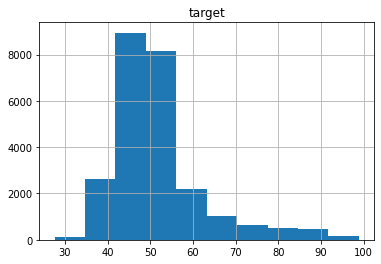

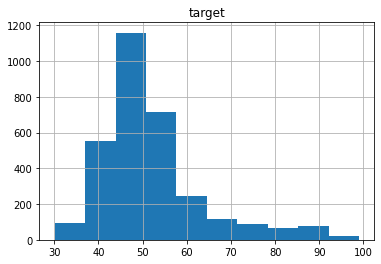

In [73]:
mixed_set_df = DataFrame.from_records(mixed_set)
mixed_set_df[mixed_set_df.set == "train"].hist()
mixed_set_df[mixed_set_df.set == "test"].hist()
len(mixed_set_df)

In [75]:
# 2021.08.26
# Numerically, there is little difference between the three splits. As such: we only keep the mixed split.

# clustered_set_df.to_csv(split_path / 'splits' / 'clustered_split.csv', index=False)
# full_set_df.to_csv(split_path / 'splits' / 'full_split.csv', index=False)

mixed_set_df.to_csv(split_path / 'splits' / 'mixed_split.csv', index=False)